In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from time import time
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.base import BaseSampler
from imblearn.pipeline import Pipeline as ImbPipeline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
TEST_SIZE = 0.2

### Extraction Features

In [2]:
df = pd.read_csv("../PreProcessing/processed_data/Resume_proc_lemm.csv")

In [ ]:
tfidf_vect = TfidfVectorizer(
    lowercase=True,
    binary=False,
    max_features=10000,
    ngram_range=(1, 6),            # unigrams fino a 6-grams
    max_df=0.8,
    min_df=2
)

In [ ]:
def smote(X_train, y_train):
    class_counts = y_train.value_counts()
    min_classes = class_counts[class_counts < 0.7*class_counts.mean()].index.tolist()
    
    print(f"Applicazione di SMOTE alle classi: {min_classes} \n")
    
    target_size = int(class_counts.max() * 0.8)
    sampling_strategy = {cls: target_size for cls in min_classes}
    
    # Applica SMOTE
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    return X_train_resampled, y_train_resampled

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Resume_str'], df['Category'], test_size=TEST_SIZE, random_state=42, stratify=df['Category'])

print("Train data size:", X_train.shape)
print("Validation data size:", X_test.shape)

Train data size: (1738,)
Validation data size: (745,)


In [ ]:
X_train_features = tfidf_vect.fit_transform(X_train)
X_test_features = tfidf_vect.transform(X_test)

In [10]:
len(tfidf_vect.vocabulary_)

10000

### Random Forest Classifier

In [ ]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: {results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
class CustomSMOTE(BaseSampler):
    def __init__(self, random_state=42):
        self.random_state = random_state

    def _fit_resample(self, X, y):
        # Conta le classi
        class_counts = pd.Series(y).value_counts()
        min_classes = class_counts[class_counts < 0.7 * class_counts.mean()].index.tolist()
        
        print(f"Applicazione di SMOTE alle classi: {min_classes} \n")
        
        target_size = int(class_counts.max() * 0.8)
        sampling_strategy = {cls: target_size for cls in min_classes}
        
        smote = SMOTE(sampling_strategy=sampling_strategy, random_state=self.random_state)
        return smote.fit_resample(X, y)


In [ ]:
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])


In [ ]:
param_grid = {
    'clf__n_estimators': [400, 700],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__max_depth' : [8, 9, 10],
    'clf__criterion' : ['gini', 'entropy']
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='f1_weighted',
    n_jobs=-1
)

start = time()
grid_search = grid.fit(X_train_features, y_train)

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")
report(grid_search.cv_results_)

GridSearchCV took 201.37 seconds for 24 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.695 (std: 0.020)
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__n_estimators': 700}

Model with rank: 2
Mean validation score: 0.693 (std: 0.016)
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 9, 'clf__max_features': 'sqrt', 'clf__n_estimators': 700}

Model with rank: 3
Mean validation score: 0.692 (std: 0.011)
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__max_features': 'sqrt', 'clf__n_estimators': 400}

Model with rank: 4
Mean validation score: 0.690 (std: 0.011)
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 9, 'clf__max_features': 'sqrt', 'clf__n_estimators': 400}

Model with rank: 5
Mean validation score: 0.690 (std: 0.012)
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__n_estimators': 400}

Model with rank: 6
Mean validation score:

In [17]:
print(grid_search.best_params_)

{'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__n_estimators': 700}


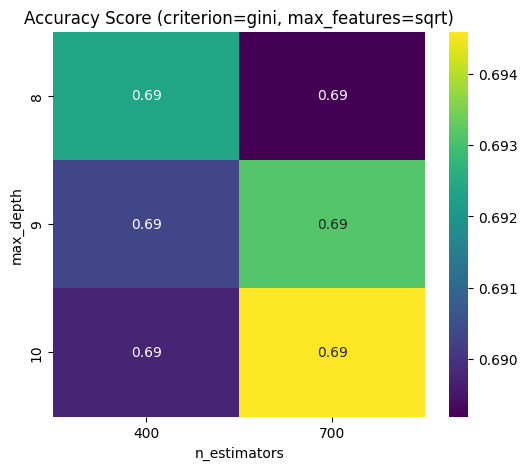

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)

filtered = results[
    (results['param_clf__criterion'] == 'gini') & 
    (results['param_clf__max_features'] == 'sqrt')
]

pvt = filtered.pivot_table(
    values='mean_test_score',
    index='param_clf__max_depth',
    columns='param_clf__n_estimators'
)

f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(pvt, cmap='viridis', annot=True, ax=ax)
plt.title('Accuracy Score (criterion=gini, max_features=sqrt)')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

In [19]:
RF_Model_best = grid_search.best_estimator_
prediction = RF_Model_best.predict(X_test_features)

In [20]:
# RF_Model_best = RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 700, max_depth=10, criterion='gini')
# RF_Model_best.fit(X_train_resampled, y_train_resampled)

In [21]:
# prediction = RF_Model_best.predict(X_test_features)

In [22]:
print("Training Score: {:.2f}".format(RF_Model_best.score(X_train_features, y_train)))
print("Test Score: {:.2f}".format(RF_Model_best.score(X_test_features, y_test)))

Training Score: 0.97
Test Score: 0.76


In [ ]:
print(classification_report(y_test, prediction))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.61      1.00      0.76        35
              ADVOCATE       0.79      0.66      0.72        35
           AGRICULTURE       0.86      0.32      0.46        19
               APPAREL       0.88      0.48      0.62        29
                  ARTS       0.88      0.23      0.36        31
            AUTOMOBILE       0.60      0.55      0.57        11
              AVIATION       0.88      0.80      0.84        35
               BANKING       0.76      0.63      0.69        35
                   BPO       0.60      0.43      0.50         7
  BUSINESS-DEVELOPMENT       0.92      0.94      0.93        36
                  CHEF       0.78      0.89      0.83        35
          CONSTRUCTION       0.94      0.85      0.89        34
            CONSULTANT       0.83      0.56      0.67        34
              DESIGNER       0.86      0.97      0.91        32
         DIGITAL-MEDIA       0.80      

<Figure size 1500x1000 with 0 Axes>

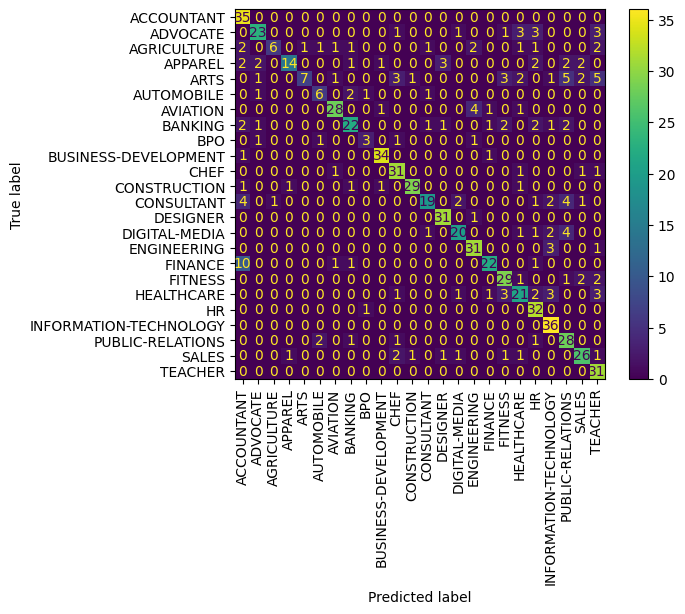

In [ ]:
plt.figure(figsize=(15, 10))
ConfusionMatrixDisplay.from_predictions(y_test, prediction)
plt.xticks(rotation=90)
plt.show()

### Analisi Overfitting

<Figure size 1500x1000 with 0 Axes>

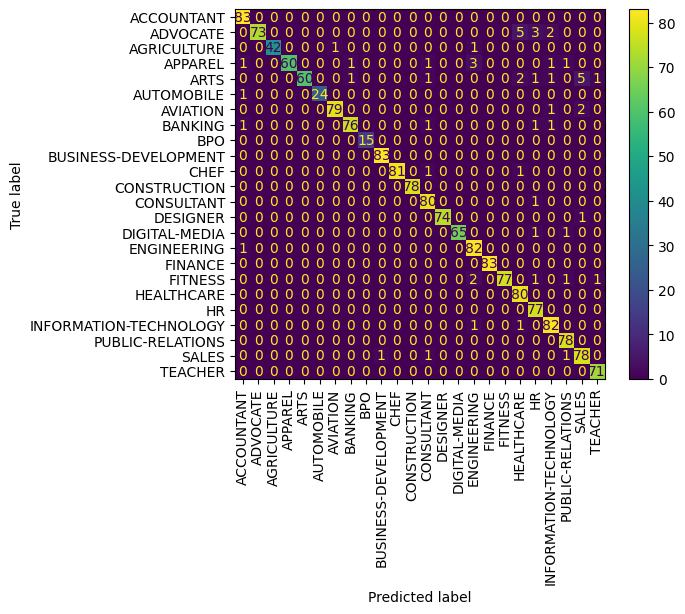

In [28]:
prediction_train = RF_Model_best.predict(X_train_features)

plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_train, prediction_train)
plt.xticks(rotation=90)
plt.show()

c:\Users\filip\anaconda3\envs\DMML\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
14 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\filip\anaconda3\envs\DMML\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\filip\anaconda3\envs\DMML\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\filip\anaconda3\envs\DMML\Lib\site-packages\imblearn\pipeline.py", line 5

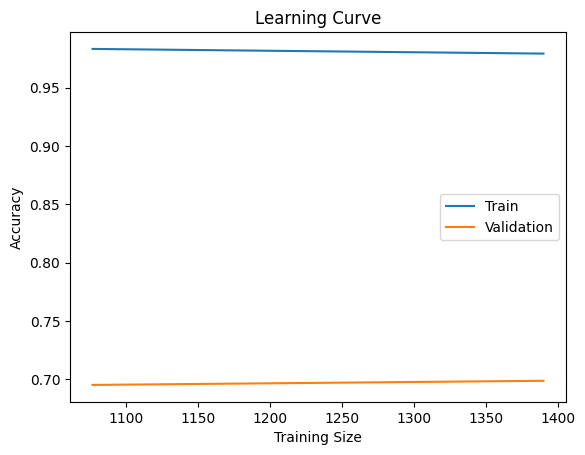

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    RF_Model_best, X_train_features, y_train, cv=skf, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Train')
plt.plot(train_sizes, test_mean, label='Validation')
plt.legend()
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.show()


### Altro Modello per diminuire overfitting

In [30]:
RF_Model = RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 400, max_depth=4, criterion='gini')
RF_Model.fit(X_train_features, y_train)

RandomForestClassifier(max_depth=4, n_estimators=400, random_state=42)

In [31]:
prediction = RF_Model.predict(X_test_features)

In [32]:
print("Training Score: {:.2f}".format(RF_Model.score(X_train_features, y_train)))
print("Test Score: {:.2f}".format(RF_Model.score(X_test_features, y_test)))

Training Score: 0.78
Test Score: 0.70


In [33]:
print(classification_report(y_test,prediction))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.50      1.00      0.67        35
              ADVOCATE       0.90      0.77      0.83        35
           AGRICULTURE       0.00      0.00      0.00        19
               APPAREL       0.88      0.24      0.38        29
                  ARTS       1.00      0.03      0.06        31
            AUTOMOBILE       0.00      0.00      0.00        11
              AVIATION       0.83      0.86      0.85        35
               BANKING       0.79      0.54      0.64        35
                   BPO       0.00      0.00      0.00         7
  BUSINESS-DEVELOPMENT       0.85      0.94      0.89        36
                  CHEF       0.69      0.89      0.78        35
          CONSTRUCTION       0.93      0.82      0.88        34
            CONSULTANT       0.72      0.62      0.67        34
              DESIGNER       0.78      0.97      0.86        32
         DIGITAL-MEDIA       0.86      

c:\Users\filip\anaconda3\envs\DMML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\filip\anaconda3\envs\DMML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\filip\anaconda3\envs\DMML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1500x1000 with 0 Axes>

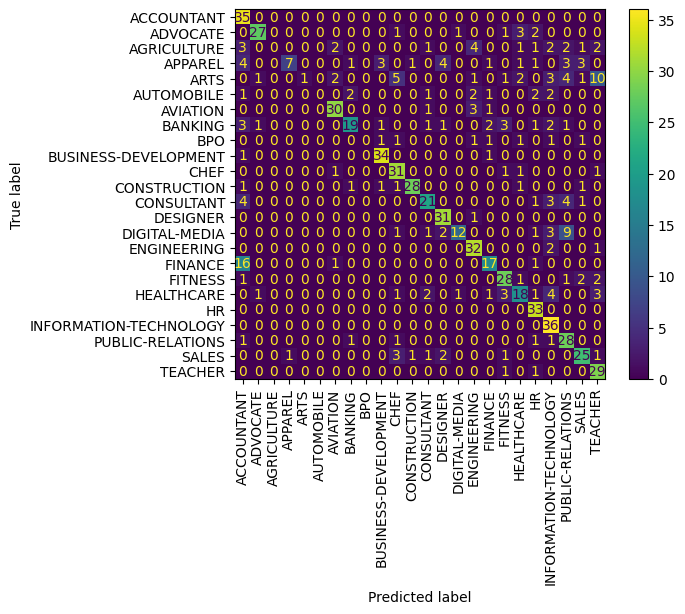

In [34]:
prediction_train = RF_Model.predict(X_test_features)

plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction_train)
plt.xticks(rotation=90)
plt.show()